In [1]:
#import dependencies
import requests
import time
import sqlite3
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint as pp
from bs4 import BeautifulSoup as bs
from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve, average_precision_score, auc
from sklearn.svm import SVC, SVR
from sklearn import svm
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

In [2]:
# create connection to database
warnings.filterwarnings('ignore')

con = sqlite3.connect("db/movies.db")
sql = f"""
   SELECT * FROM movie_data
   """

# bring in db to pandas dataframe
movieDf = pd.read_sql(sql, con)
movieDf.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,rel_mon_04,rel_mon_05,rel_mon_06,rel_mon_07,rel_mon_08,rel_mon_09,rel_mon_10,rel_mon_11,rel_mon_12,release_month
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,0,0,0,0,0,0,0,0,1,12
1,Color,Stephen Sommers,106.0,106.0,208.0,855.0,Jason Flemyng,3000.0,11146409.0,Action|Adventure|Horror|Sci-Fi,...,0,0,0,0,0,0,0,0,0,01
2,Color,Terrence Malick,222.0,150.0,0.0,855.0,Michael Greyeyes,23000.0,12712093.0,Biography|Drama|History|Romance,...,0,0,0,0,0,0,0,0,1,12
3,Color,Brian Robbins,76.0,98.0,48.0,722.0,Joel David Moore,21000.0,61112916.0,Comedy|Family|Fantasy,...,0,0,0,0,0,0,0,0,0,03
4,Color,Brad Peyton,178.0,94.0,62.0,722.0,Dwayne Johnson,14000.0,103812241.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,...,0,0,0,0,0,0,0,0,0,01


In [3]:
# review columns
for col in movieDf.columns.sort_values().values:
    print(col)

actor_1_facebook_likes
actor_1_name
actor_1_score
actor_2_facebook_likes
actor_2_name
actor_2_score
actor_3_facebook_likes
actor_3_name
actor_3_score
aspect_ratio
budget
cast_total_facebook_likes
color
content_rating
country
director_facebook_likes
director_name
director_score
duration
facenumber_in_poster
genres
genres_count
gross
gross_margin
holiday_month
imdb_num_code
imdb_score
language
movie_facebook_likes
movie_imdb_link
movie_title
num_critic_for_reviews
num_user_for_reviews
num_voted_users
plot_keywords
popularity
production_companies_count
rating_numeric
rel_mon_01
rel_mon_02
rel_mon_03
rel_mon_04
rel_mon_05
rel_mon_06
rel_mon_07
rel_mon_08
rel_mon_09
rel_mon_10
rel_mon_11
rel_mon_12
release_date
release_month
revenue
success_bins
successful
title_year
tot_noms
tot_wins
total_actor_starpower
vote_average
vote_count


In [4]:
# create table for model purposes
modelDf = movieDf[["duration","rating_numeric","budget","revenue","gross_margin", 
                   "successful","director_score","production_companies_count","total_actor_starpower","rel_mon_01",
                   "rel_mon_02", "rel_mon_03", "rel_mon_04", "rel_mon_05", "rel_mon_06", "rel_mon_07", "rel_mon_08",
                   "rel_mon_09", "rel_mon_10", "rel_mon_11", "rel_mon_12","holiday_month","tot_wins","tot_noms"]]
modelDf = modelDf.dropna()
modelDf.head(10)

,duration,rating_numeric,budget,revenue,gross_margin,successful,director_score,production_companies_count,total_actor_starpower,rel_mon_01,...,rel_mon_06,rel_mon_07,rel_mon_08,rel_mon_09,rel_mon_10,rel_mon_11,rel_mon_12,holiday_month,tot_wins,tot_noms
0,178.0,3,237000000.0,523505847.0,0.688365,1,3.091853,4.0,5.334665,0,...,0,0,0,0,0,0,1,1,0,0
1,106.0,4,45000000.0,-33853591.0,-3.037175,0,1.766773,3.0,10.933174,1,...,0,0,0,0,0,0,0,0,0,0
2,150.0,3,30000000.0,-17287907.0,-1.359958,0,1.325080,5.0,11.013046,0,...,0,0,0,0,0,0,1,1,0,0
3,98.0,2,50000000.0,11112916.0,0.181842,1,2.650160,3.0,13.698882,0,...,0,0,0,0,0,0,0,0,0,1
4,94.0,2,79000000.0,24812241.0,0.239011,1,1.325080,3.0,6.475240,1,...,0,0,0,0,0,0,0,0,0,0
5,146.0,4,100000000.0,-4671063.0,-0.048999,0,0.441693,4.0,3.409212,0,...,0,0,0,0,0,0,0,0,1,2
6,90.0,3,25000000.0,-6139597.0,-0.325528,0,2.650160,1.0,2.816560,0,...,0,0,0,1,0,0,0,0,0,0
7,121.0,4,83000000.0,-16137932.0,-0.241362,0,2.208466,1.0,6.499734,0,...,0,0,0,0,0,1,0,1,0,0
8,101.0,4,42000000.0,-28791977.0,-2.179885,0,0.883387,8.0,3.409212,0,...,0,0,1,0,0,0,0,0,0,0
9,110.0,4,45000000.0,25001065.0,0.357153,1,0.883387,4.0,3.409212,0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
modelDf["successful"].value_counts()

1    1950
0    1687
Name: successful, dtype: int64

In [93]:
# Assign X (data) and y (target)
X = modelDf[["duration","rel_mon_01","rel_mon_02", "rel_mon_03", "rel_mon_04", "rel_mon_05", "rel_mon_06",
             "rel_mon_07", "rel_mon_08", "rel_mon_09", "rel_mon_10", "rel_mon_11", "rel_mon_12","rating_numeric",
             "director_score","production_companies_count","total_actor_starpower","tot_wins","tot_noms",
             "holiday_month"]]


X2 = modelDf[['duration','rating_numeric', 'director_score','production_companies_count',
            "holiday_month","tot_wins","tot_noms", "total_actor_starpower"]]

y = modelDf["successful"].values.reshape(-1, 1)
print(X.shape, y.shape)
print(X2.shape, y.shape)


(3637, 20) (3637, 1)
(3637, 8) (3637, 1)


In [94]:
# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1158, train_size=0.80, stratify=y)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state=1158, train_size=0.80, stratify=y)


# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
X2_scaler = StandardScaler().fit(X2_train)


# Create a MinMax Scaler as an alternative
Xm_scaler = MinMaxScaler(feature_range=[0, 1])

In [96]:
pd.DataFrame(y_test)[0].value_counts()

1    390
0    338
Name: 0, dtype: int64

In [97]:
# transform the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

Xm_train_scaled = Xm_scaler.fit_transform(X_train)
Xm_test_scaled = Xm_scaler.fit_transform(X_test)

Xm2_train_scaled = Xm_scaler.fit_transform(X2_train)
Xm2_test_scaled = Xm_scaler.fit_transform(X2_test)

# Logistic Regression Model 

In [35]:
#build logistic model 
model = LogisticRegression()

#fit on training data
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
# Use our model to predict a value
predicted = model.predict(X_test_scaled)

# Score the prediction with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
testing_score = model.score(X_test_scaled,y_test)

print(f"testing_score: {testing_score}")

testing_score: 0.5673076923076923


# Deep Neural Network

In [37]:
# creating the empty squential network
modelNN = Sequential()

In [38]:
# Add the first layer where the input dimensions are features used in the model
modelNN.add(Dense(units=60, activation='relu', input_dim=20))

In [39]:
# Add the hidden layer
modelNN.add(Dense(units=60, activation='relu'))

# another layer
modelNN.add(Dense(units=60, activation='relu'))

In [40]:
# Add output layer, 2 units for "classes" of output, i.e. Yes or No 
modelNN.add(Dense(units=2, activation='softmax'))

In [41]:
# Compile the model using the adaptive learning rate optimizer "adam", spare_categorical_crossentropy
# for the loss function since we did not one-hot encode the labels and used accuracy for the training metrics.
modelNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
# Use the training data to fit (train) the model
modelNN.fit(
    X_train_scaled,
    y_train,
    epochs=300,
    shuffle=True,
    verbose=2
)

Epoch 1/300
 - 0s - loss: 0.6898 - acc: 0.5414
Epoch 2/300
 - 0s - loss: 0.6716 - acc: 0.5758
Epoch 3/300
 - 0s - loss: 0.6650 - acc: 0.6064
Epoch 4/300
 - 0s - loss: 0.6582 - acc: 0.6095
Epoch 5/300
 - 0s - loss: 0.6562 - acc: 0.6102
Epoch 6/300
 - 0s - loss: 0.6494 - acc: 0.6253
Epoch 7/300
 - 0s - loss: 0.6427 - acc: 0.6318
Epoch 8/300
 - 0s - loss: 0.6387 - acc: 0.6253
Epoch 9/300
 - 0s - loss: 0.6345 - acc: 0.6432
Epoch 10/300
 - 0s - loss: 0.6308 - acc: 0.6284
Epoch 11/300
 - 0s - loss: 0.6252 - acc: 0.6446
Epoch 12/300
 - 0s - loss: 0.6196 - acc: 0.6497
Epoch 13/300
 - 0s - loss: 0.6127 - acc: 0.6566
Epoch 14/300
 - 0s - loss: 0.6090 - acc: 0.6652
Epoch 15/300
 - 0s - loss: 0.6030 - acc: 0.6652
Epoch 16/300
 - 0s - loss: 0.5973 - acc: 0.6611
Epoch 17/300
 - 0s - loss: 0.5889 - acc: 0.6751
Epoch 18/300
 - 0s - loss: 0.5859 - acc: 0.6896
Epoch 19/300
 - 0s - loss: 0.5786 - acc: 0.6875
Epoch 20/300
 - 0s - loss: 0.5727 - acc: 0.6947
Epoch 21/300
 - 0s - loss: 0.5689 - acc: 0.6944
E

Epoch 171/300
 - 0s - loss: 0.1331 - acc: 0.9467
Epoch 172/300
 - 0s - loss: 0.1232 - acc: 0.9550
Epoch 173/300
 - 0s - loss: 0.1294 - acc: 0.9519
Epoch 174/300
 - 0s - loss: 0.1306 - acc: 0.9429
Epoch 175/300
 - 0s - loss: 0.1276 - acc: 0.9526
Epoch 176/300
 - 0s - loss: 0.1318 - acc: 0.9488
Epoch 177/300
 - 0s - loss: 0.1358 - acc: 0.9453
Epoch 178/300
 - 0s - loss: 0.1298 - acc: 0.9488
Epoch 179/300
 - 0s - loss: 0.1292 - acc: 0.9453
Epoch 180/300
 - 0s - loss: 0.1376 - acc: 0.9443
Epoch 181/300
 - 0s - loss: 0.2308 - acc: 0.9123
Epoch 182/300
 - 0s - loss: 0.2152 - acc: 0.9172
Epoch 183/300
 - 0s - loss: 0.1703 - acc: 0.9330
Epoch 184/300
 - 0s - loss: 0.1321 - acc: 0.9484
Epoch 185/300
 - 0s - loss: 0.1184 - acc: 0.9553
Epoch 186/300
 - 0s - loss: 0.1280 - acc: 0.9495
Epoch 187/300
 - 0s - loss: 0.1160 - acc: 0.9546
Epoch 188/300
 - 0s - loss: 0.1180 - acc: 0.9546
Epoch 189/300
 - 0s - loss: 0.1180 - acc: 0.9498
Epoch 190/300
 - 0s - loss: 0.1119 - acc: 0.9557
Epoch 191/300
 - 0s 

In [43]:
# evaluate model by using test data
model_loss, model_accuracy = modelNN.evaluate(
    X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

 - 0s - loss: 3.3016 - acc: 0.5179
Loss: 3.301634764933324, Accuracy: 0.5178571343421936


# Decision Tree Model w/o Hyper Parameter Tuning

In [44]:
# create model instance
modelDT = tree.DecisionTreeClassifier()

In [45]:
# Fit the classifier to the data
modelDT = modelDT.fit(X_train_scaled, y_train)

In [46]:
# Calculate the R2 score for the test data
score = modelDT.score(X_test_scaled, y_test)

print(f"Decision Tree Score: {score}")

Decision Tree Score: 0.5398351648351648


# Decision Tree Model w/ Hyper Parameter Tuning

In [47]:
# create model instance
modelDT1 = tree.DecisionTreeClassifier(random_state=1234)

In [48]:
# define hyper parameters Set
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'random_state':[123]}

In [49]:
# compile models with hyper parameters sets
modelDT1 = GridSearchCV(modelDT1, param_grid=params, n_jobs=-1)

In [50]:
# train the hyper parameter tuned DT model with the training data
modelDT1.fit(X_train_scaled,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1234,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7,

In [51]:
# print best parameters within the tuned DT model
print(f"Best Hyper Parameters: {modelDT1.best_params_}")

# make predictions with tuned DT model
predictionDT1 = modelDT1.predict(X_test_scaled)

# print accuracy (score) of tuned DT model
print(f"Accuracy: {metrics.accuracy_score(predictionDT1,y_test)}")

Best Hyper Parameters: {'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 13, 'random_state': 123}
Accuracy: 0.5439560439560439


# Random Forest Model w/o Hyper Parameter Tuning

In [52]:
# Create the RF instance
rf = RandomForestClassifier(n_estimators=300)

# fit the RF model with training data
rf = rf.fit(X_train, y_train)

# score the RF model using testing data
print(f"RF Score: {rf.score(X_test,y_test)}")

RF Score: 0.570054945054945


# Random Forest Model w/ Hyper Parameter Tuning

In [53]:
# Create the RF instance
rf1 = RandomForestClassifier()

In [54]:
#Hyper Parameters Set for RF
params = {'criterion':['gini','entropy'],
          'n_estimators':[50,100,500,1000],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7], 
          'random_state':[123],
          'n_jobs':[-1]}

In [55]:
# create models with hyper parameters
modelRf1 = GridSearchCV(rf1, param_grid=params, n_jobs=-1)

In [56]:
# train the hyper parameter tuned RF model with the training data
modelRf1.fit(X_train_scaled,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [57]:
# make predicition with test data
predictionRf1 = modelRf1.predict(X_test_scaled)

# print best  hyper parameters set
print(f"Best Hyper Parameters: {modelRf1.best_params_}")

# print score for tuned RF model
print(f"Accuracy: {metrics.accuracy_score(predictionRf1,y_test)}")

Best Hyper Parameters: {'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 123}
Accuracy: 0.5810439560439561


In [58]:
print(f"Tuned RF Model Feature Importances:\n{modelRf1.best_estimator_.feature_importances_}")

Tuned RF Model Feature Importances:
[0.21724892 0.01004161 0.01346194 0.00981803 0.01015524 0.0101785
 0.01435724 0.01293353 0.01393811 0.0173505  0.01476214 0.00856422
 0.00986871 0.06646321 0.13402584 0.12935757 0.21628251 0.01769076
 0.06059388 0.01290753]


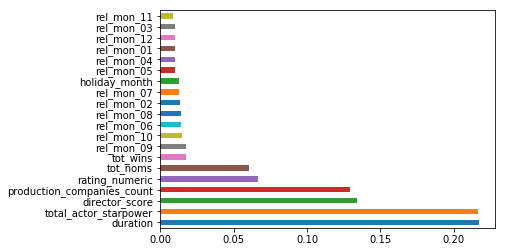

In [59]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(modelRf1.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [60]:
# make predicitions based on x test scaled data
predictions = modelRf1.predict(X_test_scaled)

#create dataframe
df = pd.DataFrame(predictions)

In [61]:
# format 
df.rename({0 : "Pred"}, axis=1, inplace=True)
df["Actual"] = y_test
df["Analysis"] = df["Actual"]-df["Pred"]
df.head()

,Pred,Actual,Analysis
0,0,0,0
1,1,0,-1
2,1,1,0
3,1,1,0
4,0,1,1


In [62]:
df["Analysis"].sum()
df["Analysis"] = df["Analysis"].map({1:"Incorrect",-1:"Incorrect",0:"Correct"})
df.head()

,Pred,Actual,Analysis
0,0,0,Correct
1,1,0,Incorrect
2,1,1,Correct
3,1,1,Correct
4,0,1,Incorrect


In [63]:
df["Analysis"].value_counts()

Correct      423
Incorrect    305
Name: Analysis, dtype: int64

In [64]:
metrics.confusion_matrix(predictions,y_test)

array([[146, 113],
       [192, 277]])

In [65]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(f"true negative: {tn:3d} false positive: {fp:3d}")
print(f"false negative: {fn:3d} true positive: {tp:3d}")

true negative: 146 false positive: 192
false negative: 113 true positive: 277


# Support Vector Machine w/o Hyper Parameter Tuning

In [66]:
# Create a support vector machine linear classifer and fit it to the training data.

target_names = ["not successful", "successful"]

modelSVC1 = SVC(kernel='linear', probability = True)
modelSVC1.fit(X_train_scaled, y_train)

modelSVC2 = SVC(kernel='rbf')
modelSVC2.fit(X_train_scaled, y_train)

modelSVC3 = SVC(kernel='poly')
modelSVC3.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [67]:
# Print model scores using the test data to compare
print(f"Linear SVC Model: {modelSVC1.score(X_test,y_test)}")
print(f"RBF SVC Model: {modelSVC2.score(X_test,y_test)}")
print(f"Polynomial SVC Model: {modelSVC3.score(X_test,y_test)}")

Linear SVC Model: 0.5357142857142857
RBF SVC Model: 0.4642857142857143
Polynomial SVC Model: 0.4642857142857143


# Support Vector Machine w/ Hyper Parameter Tuning

In [68]:
# create support vector classifier 
modelSVC = SVC()

#defining hyper parameters
params = {'C': [5,6,7,8,9,10], 
          'kernel': ['linear','rbf'],
          'gamma': [0.1,1,10,100]}

#Making models with hyper parameters sets
modelSVC = GridSearchCV(modelSVC, param_grid=params, n_jobs=-1)

In [69]:
#Learning
modelSVC.fit(X_train_scaled,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [5, 6, 7, 8, 9, 10], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [70]:
#The best hyper parameters set
print(f"Best Hyper Parameters: {modelSVC.best_params_}")

Best Hyper Parameters: {'C': 5, 'gamma': 0.1, 'kernel': 'linear'}


In [71]:
modelSVC1.coef_[0]

array([ 1.34571345e-05, -3.52043039e-01, -3.71236314e-01,  1.50830432e-01,
        1.43875470e-01,  1.49833939e-01,  1.57945958e-01,  1.55850876e-01,
        1.63484814e-01, -4.70407548e-01,  1.65379620e-01,  7.05846244e-02,
        8.40520285e-02, -1.00711049e-04,  1.90949878e-04, -3.38978982e-04,
        1.18548983e-04, -6.75262611e-05,  5.59730787e-05,  1.15357546e-01])

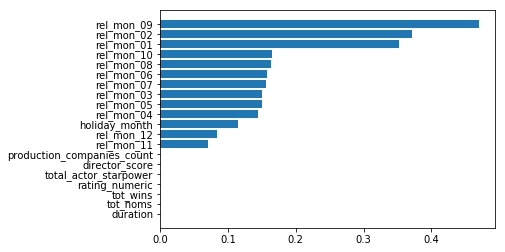

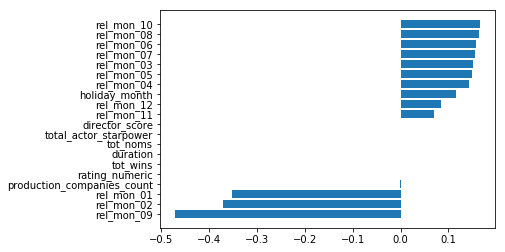

In [72]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ["duration","rel_mon_01","rel_mon_02", "rel_mon_03", "rel_mon_04", "rel_mon_05", "rel_mon_06",
             "rel_mon_07", "rel_mon_08", "rel_mon_09", "rel_mon_10", "rel_mon_11", "rel_mon_12","rating_numeric",
             "director_score","production_companies_count","total_actor_starpower","tot_wins","tot_noms",
             "holiday_month"]

f_importances(abs(modelSVC1.coef_[0]), features_names)
f_importances(modelSVC1.coef_[0], features_names)

In [73]:
# make prediction using test data
prediction = modelSVC.predict(X_test_scaled)

In [74]:
#evaluation(Accuracy)
print(f"Accuracy: {metrics.accuracy_score(prediction,y_test)}")

Accuracy: 0.5315934065934066


# QDA

In [98]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.svm import SVC

In [99]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# define model
modelQda = QuadraticDiscriminantAnalysis()

In [106]:
# Function to test PCA with a range of component values

for n in range(2,9):
    
    pca = decomposition.PCA(n_components = n)
    pca.fit(X2_train_scaled, y_train)
    X2_train_pca = pca.transform(X2_train_scaled)
    X2_test_pca = pca.transform(X2_test_scaled)
    
    modelQda.fit(X2_train_pca, y_train)
    print("n="+str(n),modelQda.score(X2_test_pca, y_test),"")

n=2 0.5302197802197802 
n=3 0.5357142857142857 
n=4 0.5412087912087912 
n=5 0.5563186813186813 
n=6 0.5576923076923077 
n=7 0.5631868131868132 
n=8 0.5604395604395604 


In [111]:
# Function to test PCA with 8 features, but this time with the MaxMin scaler (Xm)

for n in range(2,9):
    
    pca = decomposition.PCA(n_components = n)
    pca.fit(Xm2_train_scaled, y_train)
    Xm2_train_pca = pca.transform(Xm2_train_scaled)
    Xm2_test_pca = pca.transform(Xm2_test_scaled)
    
    modelQda.fit(Xm2_train_pca, y_train)
    print("n="+str(n),modelQda.score(Xm2_test_pca, y_test),"")



n=2 0.5357142857142857 
n=3 0.5274725274725275 
n=4 0.5494505494505495 
n=5 0.5686813186813187 
n=6 0.5782967032967034 
n=7 0.5755494505494505 
n=8 0.5837912087912088 


In [113]:
# Function to test PCA with 8 features, but this time with the MaxMin scaler (Xm)
    
pca = decomposition.PCA(n_components = 8)
pca.fit(Xm2_train_scaled, y_train)
Xm2_train_pca = pca.transform(Xm2_train_scaled)
Xm2_test_pca = pca.transform(Xm2_test_scaled)

modelQda.fit(Xm2_train_pca, y_train)
print("n="+str(n),modelQda.score(Xm2_test_pca, y_test),"")



n=8 0.5837912087912088 


In [114]:
# Use our model to predict a value
predicted = modelQda.predict(Xm2_test_pca)

# Score the prediction with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
testing_score = modelQda.score(Xm2_test_pca,y_test)

print(f"mean squared error: {mse}")
print(f"r2: {r2}")
print(f"testing_score: {testing_score}")

mean squared error: 0.41620879120879123
r2: -0.6733727810650889
testing_score: 0.5837912087912088


# AdaBoost


In [148]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Create adaboost classifier object
modelAda = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)

# Function to test PCA with an optimal number of components equals 6
pca = decomposition.PCA(n_components = 6)
pca.fit(X2_train_scaled, y_train)
X2_train_pca = pca.transform(X2_train_scaled)
X2_test_pca = pca.transform(X2_test_scaled)

# fit the AdaBoost model with 8 feature dataset
modelAda.fit(X2_train_pca, y_train)
print("n="+str(n),modelAda.score(X2_test_pca, y_test))

n=8 0.5563186813186813


# Summary of Models and Scores

In [149]:
print(f"Models WITHOUT Hyper Parameter Tuning")
print(f"------------------")
print(f"Decision Tree: {modelDT.score(X_test_scaled, y_test)}")
print(f"Random Forest: {rf.score(X_test_scaled, y_test)}")
print(f"Support Vector Machine: {modelSVC1.score(X_test,y_test)}")
print("-------------------------")
print(f"Model scores WITH Hyper Parameter Tuning")
print(f"Decision Tree: {metrics.accuracy_score(predictionDT1,y_test)}")
print(f"Random Forest: {metrics.accuracy_score(predictionRf1,y_test)}")
print(f"Support Vector Machine: {metrics.accuracy_score(prediction,y_test)}")
print(f"Deep Neural Network: {model_accuracy}")
print(f"QDA: {modelQda.score(Xm2_test_pca,y_test)}")
print(f"AdaBoost: {modelAda.score(X2_test_pca, y_test)}")

Models WITHOUT Hyper Parameter Tuning
------------------
Decision Tree: 0.5398351648351648
Random Forest: 0.5
Support Vector Machine: 0.5357142857142857
-------------------------
Model scores WITH Hyper Parameter Tuning
Decision Tree: 0.5439560439560439
Random Forest: 0.5810439560439561
Support Vector Machine: 0.5315934065934066
Deep Neural Network: 0.5178571343421936
QDA: 0.5837912087912088
AdaBoost: 0.5563186813186813


# ROC Curve (Receiving Operator Characteristic) & CAP (Cumulative Accuracy Profile)

Qda AUC (Area Under Curve): 0.581
Random Forest AUC (Area Under Curve): 0.610
AdaBoost (Area Under Curve): 0.575




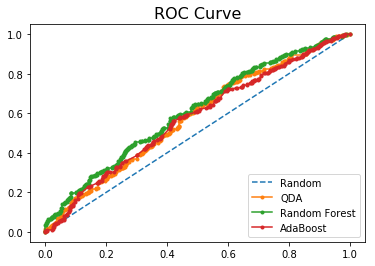

In [151]:
# predict probabilities
probsQda = modelQda.predict_proba(Xm2_test_pca)
probsRf = modelRf1.predict_proba(X_test_scaled)
probsAda = modelAda.predict_proba(X2_test_pca)

# keep probabilities for the positive outcome only
probsQda = probsQda[:, 1]
probsRf = probsRf[:, 1]
probsAda = probsAda[:, 1]

# calculate AUC for NN,RF, Qda, Ada models
aucQda = roc_auc_score(y_test, probsQda)
aucRf = roc_auc_score(y_test, probsRf)
aucAda = roc_auc_score(y_test,probsAda)
print('Qda AUC (Area Under Curve): %.3f' % aucQda)
print('Random Forest AUC (Area Under Curve): %.3f' % aucRf)
print('AdaBoost (Area Under Curve): %.3f' % aucAda)
print('\n')
# calculate roc curve
fprQda, tprQda, thresholdsQda = roc_curve(y_test, probsQda)
fprRf, tprRf, thresholdsRf = roc_curve(y_test, probsRf)
fprAda, tprAda, thresholdAda = roc_curve(y_test, probsAda)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--', label="Random")
# plot the Qda roc curve
pyplot.plot(fprQda, tprQda, marker='.', label="QDA")
# plot the Random Forest ROC curve 
pyplot.plot(fprRf, tprRf, marker = '.', label = "Random Forest")
# plot the Ada ROC curve 
pyplot.plot(fprAda, tprAda, marker = '.', label = "AdaBoost")
# title
plt.title('ROC Curve', fontsize = 16)
# legend
plt.legend(loc = 'lower right', fontsize = 10)
# show the plot
pyplot.show()

# Cumulative Accuracy Profile

In [120]:
total = len(y_test)
class_1_count = np.sum(y_test)
class_0_count = total - class_1_count

print(f"Total: {total}")
print(f"Class 1 Count: {class_1_count}")
print(f"Class 0 Count: {class_0_count}")

Total: 728
Class 1 Count: 390
Class 0 Count: 338


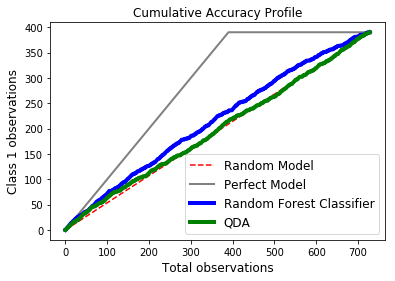

In [152]:
# plot a random model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# plot a perfect model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# creat plot for Random Forest model to compare
probs = modelRf1.predict_proba(X_test_scaled)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y_test), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)

# creat plot for Qda model to compare
probsQda = modelQda.predict_proba(Xm2_test_scaled)
probsQda = probsQda[:, 1]
model_y = [y for _, y in sorted(zip(probsQda, y_test), reverse = True)]
y_valuesQda = np.append([0], np.cumsum(model_y))
x_valuesQda = np.arange(0, total + 1)

plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Random Forest Classifier', 
         linewidth = 4)

plt.plot(x_valuesQda, 
         y_valuesQda, 
         c = 'g', 
         label = 'QDA', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)